## Feature Importance Algorithms

### Implemented four different algorithms to find the ranks of independant features according to their importance in determining the value of dependant variable

### Four methods are:       
#### 1.Anova         
#### 2.Welch Anova
#### 3.Decision Tree Classifier
#### 4.Linear Discriminant Analysis

In [1]:
# Importing all different libraries required
import pandas as pd
import numpy as np
from scipy import stats 
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
import matplotlib
import matplotlib.pyplot as plt; plt.rcdefaults()
import pingouin as pg
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Lets define certain functions required to pre-process our dataframe into the form which are required for the algorithms

#Changing the datatype of any variable if required
def set_datatypes(df,convert_dict):
    df =df.astype(convert_dict) 
    return df

#Scaling the numerical variables
def scaler(df,scale_list):
    for feature in scale_list:
        df[feature]= StandardScaler().fit_transform(df[feature].values.reshape(-1,1))
    return df

#One-hot encoding the list of variables chosen as per user's requirements
def one_hot_encode(df,encode_list):
    for feature in encode_list:
        df = pd.concat([df,pd.get_dummies(df[feature], prefix=feature,dummy_na=True)],axis=1).drop([feature],axis=1)
    return df

#Label encoding the variables specified by the user
def label_encode(df,encode_list):
    for feature in encode_list:
        label_encoder = preprocessing.LabelEncoder() 
        df[feature]= label_encoder.fit_transform(df[feature]) 
    return df

#Handling date by separating the day, month and year
def handle_date(df,date_columns,categorical_feature):
    for column in date_columns:
        day_label=column+'_day'
        month_label=column+'_month'
        year_label=column+'_year'
        df[day_label] = df[column].dt.day
        df[month_label] = df[column].dt.month
        df[year_label] = df[column].dt.year
        df.drop([column],axis=1, inplace=True)
        convert_dict={day_label:'object',month_label:'object',year_label:'object'}
        categorical_feature.append(day_label)
        categorical_feature.append(month_label)
        categorical_feature.append(year_label)
        df=set_datatypes(df,convert_dict)
    return df

# The function which actually calls all the above functions to preprocess the df
def preprocess_df(df,target_list,encode_list,one_hot_encode_flag):
    columns = list(df.head())
    numeric_columns = df._get_numeric_data().columns
    date_columns= df.select_dtypes(include=[np.datetime64])
    categorical_columns=list(set(columns) - set(numeric_columns)-set(date_columns))
    features=[column for column in columns if column not in target_list]
    numeric_feature=[feature for feature in features if feature in numeric_columns]
    categorical_feature=[feature for feature in features if feature in categorical_columns]
    date_feature=[feature for feature in features if feature in date_columns]
    numeric_target_list=[res for res in target_list if res in numeric_columns]
    categorical_target_list=[res for res in target_list if res in categorical_columns]
    date_target_list=[res for res in target_list if res in date_columns]
    df=handle_date(df,date_columns,categorical_feature)
    columns = list(df.head(0))
    for column in columns:
        if column not in target_list:
            if(len(df[column].unique())>200):
                df=df.drop([column], axis=1)
                categorical_feature.remove(column) 
    # Here you can control whether or not the variables are to be one-hot encoded.
    # For some methods like welch anova one-hot encoding is not required.This case can be handled here.
    if one_hot_encode_flag:
        df=one_hot_encode(df,categorical_feature)
    df=scaler(df,numeric_columns)
    df=label_encode(df,encode_list)
        
    return df,target_list,numeric_feature,numeric_target_list,categorical_target_list,date_target_list  

In [3]:
# This class implements the ANOVA method of ranking the features.The Categorical variables are one hot encoded and the ranks are determined
class feature_rank_anova:
   
    def __init__(self,df,target_list,numeric_target_list,categorical_target_list,date_target_list):
        self.df = df
        self.target_list = target_list
        self.numeric_target_list=numeric_target_list
        self.categorical_target_list=categorical_target_list
        self.date_target_list=date_target_list
        self.Report_df=pd.DataFrame()
        self.Report_df = pd.DataFrame(columns = ['Target', 'Feature','Rank','F-Score','P-Value','P-Value Range','F-Score Mean','Insight Text']) 
        self.results_generate()
        return
    
    def results_generate(self):
        for target in self.target_list:
            y = self.df[target].values
            X=pd.DataFrame()
            new_feature=list(column for column in list(self.df.head(0)) if column not in self.target_list)
            X=self.df[new_feature]
            
            # It is checked whether the target metric is categorical or numerical.
            # For categorical target f_classif is used
            # For numerical target f_regression is used
            
            if target in categorical_target_list:
                scores,pvalues=f_classif(X,y)
            else:
                scores,pvalues=f_regression(X,y)
            Final_features=pd.DataFrame()
            Final_features['Feature']=new_feature
            Final_features['F_Scores']=scores
            Final_features['P_Values']=pvalues
            Final_features = Final_features.sort_values(by=['F_Scores','P_Values'],ascending=[False,True])
            Final_features['Rank']=range(1,len(new_feature)+1)

            list1=[str(round(Final_features.loc[:,"P_Values"].min(),3)),'-',str(round(Final_features.loc[:,"P_Values"].max(),3))]
            p_value_range=' '.join(list1)
            Final_features.set_index('Rank', inplace=True)
            for rank in range(1,len(new_feature)+1,1):
                feature=Final_features.get_value(rank,'Feature') 
                f_score=round(Final_features.get_value(rank,'F_Scores') ,3)
                p_value=round(Final_features.get_value(rank,'P_Values'),3)
                ratio=round((Final_features.get_value(rank,'F_Scores')/Final_features.loc[:,"F_Scores"].mean()),3)
                mean=round(Final_features.loc[:,"F_Scores"].mean(),3)
                
                insight_text="Applying Anova tests we calculated relevance of "+feature+" for "+target+","+" we rank this feature "+str(rank)+"."+"We get a F-Score of "+str(f_score) +" and a P-Value of "+str(p_value)+"."+"The P-Values for features with target "+target+" range from "+p_value_range+"."+"The F-Score for "+feature+" is "+str(ratio)+ " times of the mean F-score("+str(mean)+") for target "+target+"."
                index=len(self.Report_df)
                self.Report_df = self.Report_df.T
                self.Report_df[index]=[ target,
                                      feature,
                                      rank,
                                      f_score, 
                                      p_value,
                                      p_value_range,
                                      mean,
                                      insight_text] 
                self.Report_df = self.Report_df.T
            
            # It creates a csv file to store the report created by Anova 
            f = open('Anova_Report.csv', "w")
            f.write(self.Report_df.to_csv(index=False))
            f.close()

            plot_df = Final_features[0:20]

            ordered_df = plot_df.sort_values(by='F_Scores').reset_index(drop=True)
            my_range = range(1, len(plot_df.index) + 1)

            plt.hlines(y=my_range, xmin=0, xmax=ordered_df['F_Scores'],
                           color='skyblue')
            plt.plot(ordered_df['F_Scores'], my_range, 'o', markersize=11)
            plt.yticks(ordered_df.index+1, ordered_df['Feature'])
            plt.xlabel('F_Scores')
            plt.title('F_Scores for '+target)

            plt.show()
        return

In [4]:
# This class implements the Welch ANOVA method of ranking the features.The Categorical variables are left as it is in this case.And the ranks are determined
class feature_rank_welch:
   
    def __init__(self,df,target_list):
        self.df = df
        self.target_list = target_list
        self.Report_df=pd.DataFrame()
        self.Report_df = pd.DataFrame(columns = ['Target', 'Feature','Rank','F-Score','P-Value','P-Value Range','F-Score Mean','Insight Text']) 
        self.results_generate()
        return
    
    def results_generate(self):
        for target in self.target_list:
            scores=[]
            pvalues=[]
            new_feature=[col for col in list(self.df.head(0)) if col not in self.target_list
                                                            and col not in self.df._get_numeric_data().columns]
            for feature in list(new_feature):
                f_score=self.df.welch_anova(dv=target, between=feature).get_value(0,'F')
                p_value=self.df.welch_anova(dv=target, between=feature).get_value(0,'p-unc')
                
                scores.append(f_score)
                pvalues.append(p_value)
                #print(pairwise_gameshowell(dv='flight_delay', between=feature,data=self.df))
            Final_features=pd.DataFrame()
            Final_features['Feature']=new_feature
            Final_features['F_Scores']=scores
            Final_features['P_Values']=pvalues
            Final_features = Final_features.sort_values(by=['F_Scores','P_Values'],ascending=[False,True])
            Final_features['Rank']=range(1,len(new_feature)+1)

            list1=[str(round(Final_features.loc[:,"P_Values"].min(),3)),'-',str(round(Final_features.loc[:,"P_Values"].max(),3))]
            p_value_range=' '.join(list1)
            Final_features.set_index('Rank', inplace=True)
            for rank in range(1,len(new_feature)+1,1):
                feature=Final_features.get_value(rank,'Feature') 
                f_score=round(Final_features.get_value(rank,'F_Scores') ,3)
                p_value=round(Final_features.get_value(rank,'P_Values'),3)
                ratio=round((Final_features.get_value(rank,'F_Scores')/Final_features.loc[:,"F_Scores"].mean()),3)
                mean=round(Final_features.loc[:,"F_Scores"].mean(),3)
                
                insight_text="Applying Welch-Anova tests we calculated relevance of "+feature+" for "+target+","+" we rank this feature "+str(rank)+"."+"We get a F-Score of "+str(f_score) +" and a P-Value of "+str(p_value)+"."+"The P-Values for features with target "+target+" range from "+p_value_range+"."+"The F-Score for "+feature+" is "+str(ratio)+ " times of the mean F-score("+str(mean)+") for target "+target+"."
                index=len(self.Report_df)
                self.Report_df = self.Report_df.T
                self.Report_df[index]=[ target,
                                      feature,
                                      rank,
                                      f_score, 
                                      p_value,
                                      p_value_range,
                                      mean,
                                      insight_text] 
                self.Report_df = self.Report_df.T

            f = open('Welch_Report.csv', "w")
            f.write(self.Report_df.to_csv(index=False))
            f.close()

            plot_df = Final_features[0:20]

            ordered_df = plot_df.sort_values(by='F_Scores').reset_index(drop=True)
            my_range = range(1, len(plot_df.index) + 1)

            plt.hlines(y=my_range, xmin=0, xmax=ordered_df['F_Scores'],
                           color='skyblue')
            plt.plot(ordered_df['F_Scores'], my_range, 'o', markersize=11)
            plt.yticks(ordered_df.index+1, ordered_df['Feature'])
            plt.xlabel('F_Scores')
            plt.title('F_Scores for '+target)

            plt.show()
        return

In [5]:
# This class implements the Decision Tree method of ranking the features.The Categorical variables are one hot encoded and the ranks are determined
class feature_rank_dtc:
   
    def __init__(self,df,target_list,numeric_target_list,categorical_target_list,date_target_list):
        self.df = df
        self.target_list = target_list
        self.numeric_target_list=numeric_target_list
        self.categorical_target_list=categorical_target_list
        self.date_target_list=date_target_list
        self.Report_df=pd.DataFrame()
        self.Report_df = pd.DataFrame(columns = ['Target', 'Feature','Rank','Score','Score Mean','Insight Text']) 
        self.results_generate()
        return
    
    def results_generate(self):
        for target in self.target_list:
            
            y = self.df[target].values
            X=pd.DataFrame()
            new_feature=list(column for column in list(self.df.head(0)) if column not in self.target_list)
            Final_features=pd.DataFrame()
            Final_features['Feature']=new_feature
            X=self.df[new_feature]
            if target in self.categorical_target_list:
                forest = ExtraTreesClassifier(random_state=0)
                forest.fit(X, y)
                importances = forest.feature_importances_
                std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                             axis=0)
                indices = np.argsort(importances)[::-1]

                scores=[]
                feature=[]
                for f in range(X.shape[1]):
                    scores.append(round((importances[indices[f]]),3))
                    feature.append(Final_features.get_value(indices[f],'Feature'))
                importance_dictionary=dict(zip(new_feature,scores))
            else:
                regressor = DecisionTreeRegressor(random_state=0)
                regressor=regressor.fit(X,y)
                importance_dictionary=dict(zip(new_feature,list(regressor.feature_importances_)))
            
            Final_features['Scores']=Final_features['Feature'].map(importance_dictionary)
            Final_features = Final_features.sort_values(by='Scores',ascending=False)
            Final_features['Rank']=range(1,len(new_feature)+1)
            Final_features.set_index('Rank', inplace=True)
            for rank in range(1,len(new_feature)+1,1):
                feature=Final_features.get_value(rank,'Feature') 
                score=round(Final_features.get_value(rank,'Scores') ,3)
                ratio=round((Final_features.get_value(rank,'Scores')/Final_features.loc[:,"Scores"].mean()),3)
                mean=round(Final_features.loc[:,"Scores"].mean(),3)
                
                insight_text="Applying Decision Tree  we calculated importances of "+feature+" for "+target+","+" we rank this feature "+str(rank)+"."+"We get a Score of "+str(score)+"."+"The Score for "+feature+" is "+str(ratio)+ " times of the mean scores("+str(mean)+") for target "+target+"."
                index=len(self.Report_df)
                self.Report_df = self.Report_df.T
                self.Report_df[index]=[ target,
                                      feature,
                                      rank,
                                      score, 
                                      mean,
                                      insight_text] 
                self.Report_df = self.Report_df.T

            f = open('DTC_Report.csv', "w")
            f.write(self.Report_df.to_csv(index=False))
            f.close()

            plot_df = Final_features[0:20]

            ordered_df = plot_df.sort_values(by='Scores').reset_index(drop=True)
            my_range = range(1, len(plot_df.index) + 1)

            plt.hlines(y=my_range, xmin=0, xmax=ordered_df['Scores'],
                           color='skyblue')
            plt.plot(ordered_df['Scores'], my_range, 'o', markersize=11)
            plt.yticks(ordered_df.index+1, ordered_df['Feature'])
            plt.xlabel('Scores')
            plt.title('Scores for '+target)

            plt.show()
        return

In [6]:
# This class implements the LDA method of ranking the features.The Categorical variables are one hot encoded and the ranks are determined only for categorical targets
class feature_rank_lda:
   
    def __init__(self,df,numeric_feature,target_list,numeric_target_list,categorical_target_list,date_target_list):
        self.df = df
        self.numeric_feature=numeric_feature
        self.target_list = target_list
        self.numeric_target_list=numeric_target_list
        self.categorical_target_list=categorical_target_list
        self.date_target_list=date_target_list
        self.Report_df=pd.DataFrame()
        self.Report_df = pd.DataFrame(columns = ['Target', 'Feature','Rank','F-Score','F-Score Mean','Insight Text']) 
        self.results_generate()
        return
    
    def results_generate(self):
        for target in self.target_list:
            y = self.df[target].values
            X=pd.DataFrame()
            new_feature=list(column for column in list(self.df.head(0)) if column not in self.target_list)
            X=self.df[new_feature]
            if target in self.categorical_target_list:
                lda = LinearDiscriminantAnalysis(n_components=2)
                X_lda = lda.fit(X, y).transform(X)
                scores=abs(lda.coef_[0]).tolist()
            else:
                continue
            Final_features=pd.DataFrame()
            Final_features['Feature']=new_feature
            Final_features['Scores']=scores
            Final_features = Final_features.sort_values(by='Scores',ascending=False)
            Final_features['Rank']=range(1,len(new_feature)+1)

            Final_features.set_index('Rank', inplace=True)
            for rank in range(1,len(new_feature)+1,1):
                feature=Final_features.get_value(rank,'Feature') 
                scores=round(Final_features.get_value(rank,'Scores') ,3)
                ratio=round((Final_features.get_value(rank,'Scores')/Final_features.loc[:,"Scores"].mean()),3)
                mean=round(Final_features.loc[:,"Scores"].mean(),3)
                
                insight_text="Applying LDA we calculated relevance of "+feature+" for "+target+","+" we rank this feature "+str(rank)+"."+"We get a F-Score of "+str(scores) +"."+"The F-Score for "+feature+" is "+str(ratio)+ " times of the mean F-score("+str(mean)+") for target "+target+"."
                index=len(self.Report_df)
                self.Report_df = self.Report_df.T
                self.Report_df[index]=[ target,
                                      feature,
                                      rank,
                                      scores, 
                                      mean,
                                      insight_text] 
                self.Report_df = self.Report_df.T

            f = open('LDA_Report.csv', "w")
            f.write(self.Report_df.to_csv(index=False))
            f.close()

            plot_df = Final_features[0:20]

            ordered_df = plot_df.sort_values(by='Scores').reset_index(drop=True)
            my_range = range(1, len(plot_df.index) + 1)

            plt.hlines(y=my_range, xmin=0, xmax=ordered_df['Scores'],
                           color='skyblue')
            plt.plot(ordered_df['Scores'], my_range, 'o', markersize=11)
            plt.yticks(ordered_df.index+1, ordered_df['Feature'])
            plt.xlabel('Scores')
            plt.title('Scores for '+target)

            plt.show()
        return

In [7]:
data=input("Enter the file name: ")
if data.endswith('.csv'):
    df = pd.read_csv(data)
else:
    df = pd.read_excel(data) 
df.dropna(how="any",axis='rows' ,inplace=True) # to drop the empty line at file-end
df = df.reset_index(drop = True) 

columns = list(df.head(0))
print("The columns in dataset with their datatypes are:")
for col in columns:
    print(col+' '+ str(df[col].dtype))
n = int(input("Enter the no. of columns you would like to change:"))
convert_dict = dict(input().split() for _ in range(n))
print("The columns in dataset include:")
print(str(columns)[1:-1]) 
df=set_datatypes(df,convert_dict)
input_string = input("Enter the variables to be considered as response(separated by space): ")
response_list = input_string.split()
input_string = input("Enter the variables you would like to label encode: ")
label_encode_list = input_string.split()


Enter the file name: flight_schedule_data.xlsx
The columns in dataset with their datatypes are:
term object
orgn object
hour int64
dest object
adft object
flno object
alc object
month int64
regn object
actp object
ttyp object
gate object
day int64
flda datetime64[ns]
delay_status object
flight_delay int64
Enter the no. of columns you would like to change:3
hour object
month object
day object
The columns in dataset include:
'term', 'orgn', 'hour', 'dest', 'adft', 'flno', 'alc', 'month', 'regn', 'actp', 'ttyp', 'gate', 'day', 'flda', 'delay_status', 'flight_delay'
Enter the variables to be considered as response(separated by space): flight_delay delay_status
Enter the variables you would like to label encode: delay_status


C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Pooja\AppData\Roaming\Python\Python36\site-packages\pingouin\parametric.py:1221: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.mean()).sum() / weights.sum()
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\AppData\Roaming\Python\Python36\site-packages\pingouin\parametric.py:1225: RuntimeWarning: invalid value encountered in double_scalars
  ms_tr = ss_tr / ddof1
C:\Users\

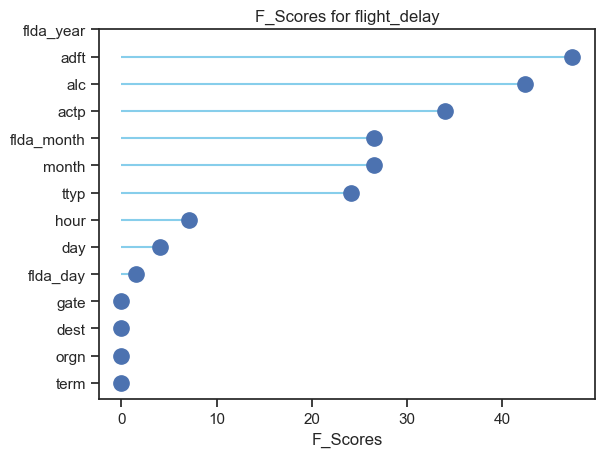

C:\Users\Pooja\AppData\Roaming\Python\Python36\site-packages\pingouin\parametric.py:1221: RuntimeWarning: invalid value encountered in double_scalars
  adj_grandmean = (weights * grp.mean()).sum() / weights.sum()
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\AppData\Roaming\Python\Python36\site-packages\pingouin\parametric.py:1225: RuntimeWarning: divide by zero encountered in double_scalars
  ms_tr = ss_tr / ddof1
C:\Users\Pooja\AppData\Roaming\Python\Python36\site-packages\pingouin\parametric.py:1229: RuntimeWarning: invalid value encountered in double_scalars
  (1 - (weights / weights.sum()))**2)) / (r**2 - 1)
C:\Users\Pooja\Anacond

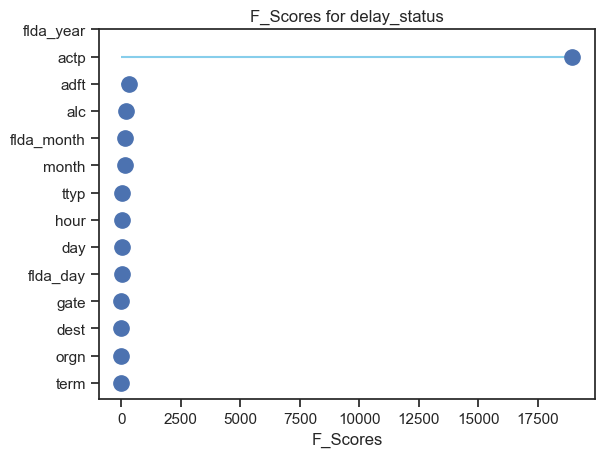

In [8]:
processed_df,response_list,numeric_feature,numeric_target_list,categorical_target_list,date_target_list=preprocess_df(df,response_list,label_encode_list,one_hot_encode_flag=False)

fr=feature_rank_welch(processed_df,response_list)

C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:279: RuntimeWarning: invalid value encountered in true_divide
  corr /= row_norms(X.T)
C:\Users\Pooja\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Pooja\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Pooja\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning:

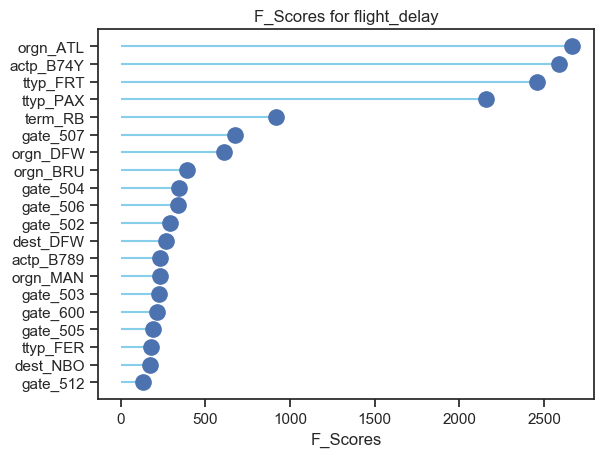

C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [  2   8 169 194 353 356 360 366 387 395 563 571] are constant.
  UserWarning)
C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: get_value is deprecated and will be removed in a future relea

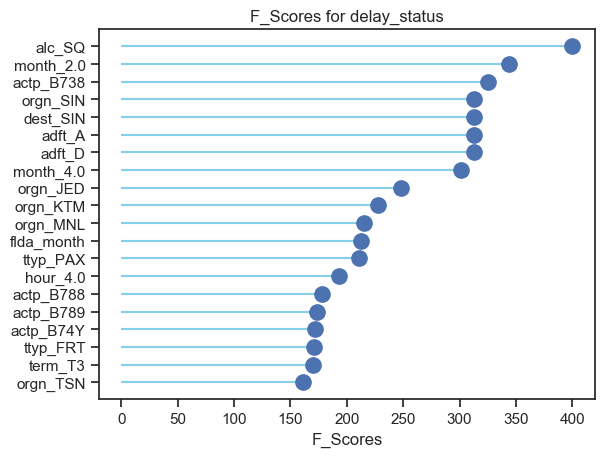

In [9]:
processed_df,response_list,numeric_feature,numeric_target_list,categorical_target_list,date_target_list=preprocess_df(df,response_list,label_encode_list,True)

fr=feature_rank_anova(processed_df,response_list,numeric_target_list,categorical_target_list,date_target_list)

C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


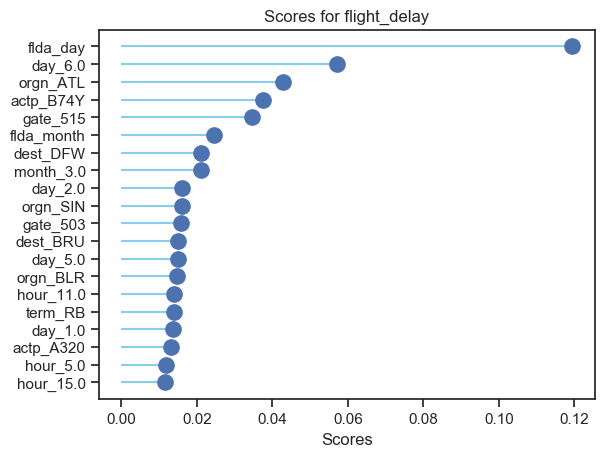

C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


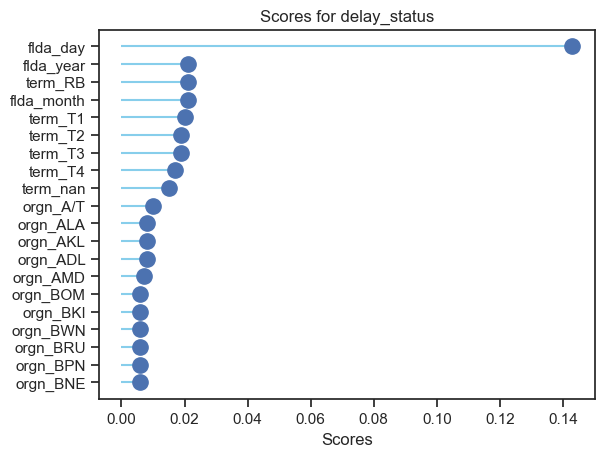

In [10]:
processed_df,response_list,numeric_feature,numeric_target_list,categorical_target_list,date_target_list=preprocess_df(df,response_list,label_encode_list,True)

fr=feature_rank_dtc(processed_df,response_list,numeric_target_list,categorical_target_list,date_target_list)

C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Pooja\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


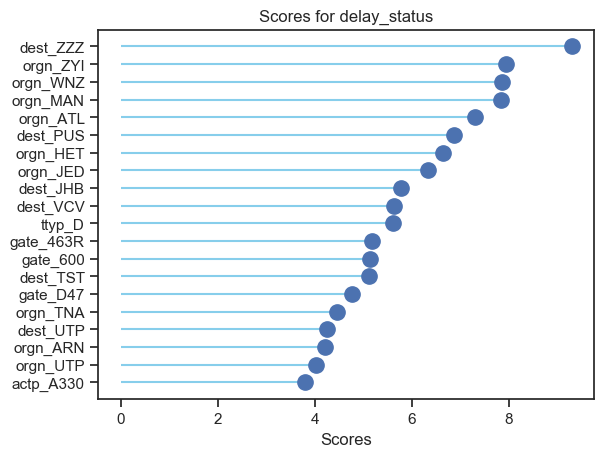

In [11]:
processed_df,response_list,numeric_feature,numeric_target_list,categorical_target_list,date_target_list=preprocess_df(df,response_list,label_encode_list,True)
fr=feature_rank_lda(processed_df,numeric_feature,response_list,numeric_target_list,categorical_target_list,date_target_list)